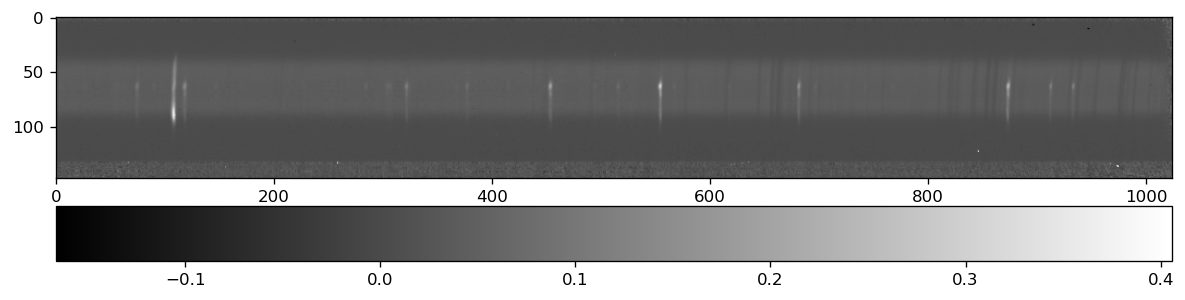

In [293]:
# import packages
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model

import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data from order 36
nirspec7_data = []
for i in range(filesize):
    n = i + 22 # fits index starts from 22
    if n < 100:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
        #nirspec7_header.append(hdu_data[1])
    elif n >= 100 and n < 112: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
        #nirspec7_header.append(hdu_data[1])
    elif n >= 112:
        break
nirspec7_data_array = np.array(nirspec7_data)

"""
# load fits header from raw
nirspec7_header = []
for i in range(filesize):
    n = i + 22 # fits index starts from 22
    if n < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(n), ignore_missing_end=True)[0].header
        nirspec7_header.append(hdu_header)
    elif n >= 100 and n < 112: # fits index ends at 111
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(n), ignore_missing_end=True)[0].header
        nirspec7_header.append(hdu_header)
    elif n >= 112:
        break
"""

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-22], 
                              nirspec7_data_array[33-22], 
                              nirspec7_data_array[34-22], 
                              nirspec7_data_array[35-22], 
                              nirspec7_data_array[36-22], 
                              nirspec7_data_array[37-22], 
                              nirspec7_data_array[38-22], 
                              nirspec7_data_array[39-22], 
                              nirspec7_data_array[40-22], 
                              nirspec7_data_array[41-22],), axis=0)

# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-22], 
                                 nirspec7_data_array[23-22], 
                                 nirspec7_data_array[24-22],
                                 nirspec7_data_array[25-22], 
                                 nirspec7_data_array[26-22], 
                                 nirspec7_data_array[27-22], 
                                 nirspec7_data_array[28-22], 
                                 nirspec7_data_array[29-22], 
                                 nirspec7_data_array[30-22], 
                                 nirspec7_data_array[31-22],), axis=0)

# sky frames confirmed 
sky51 = nirspec7_data_array[51-22] # jun02s0051_order36.fits
sky59 = nirspec7_data_array[59-22] # jun02s0059_order36.fits
sky60 = nirspec7_data_array[60-22] # jun02s0060_order36.fits
sky72 = nirspec7_data_array[72-22] # jun02s0072_order36.fits
sky78 = nirspec7_data_array[78-22] # jun02s0078_order36.fits
sky79 = nirspec7_data_array[79-22] # jun02s0079_order36.fits
sky91 = nirspec7_data_array[91-22] # jun02s0091_order36.fits
sky103 = nirspec7_data_array[103-22] # jun02s0103_order36.fits

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(n):
    start = 1 # fits index start, min >= 1, max <= n
    end = 112 # fits index end, min >= n, max <= 999
    
    if n >= start and n < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(n), ignore_missing_end=True)[0].header
    elif n >= 10 and n < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(n), ignore_missing_end=True)[0].header
    elif n >= 100 and n < end:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(n), ignore_missing_end=True)[0].header
    elif n >= end:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
sky1 = sky60
sky2 = sky72

t1 = fits_header_utc_to_second(60) 
t2 = fits_header_utc_to_second(72)
td = fits_header_utc_to_second(61)

sky_total = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
sky_subtracted = (nirspec7_data_array[61-22] - sky_total) / (average_flat_field - average_flat_lamp_off)
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
plt.figure(figsize=(12,6), dpi=120)
plt.imshow(sky_subtracted, cmap='gist_gray')
#plt.gca().invert_yaxis()
#plt.xlim(100,120)
#plt.ylim(40,0)
plt.colorbar(orientation='horizontal', pad=0.05)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

<ErrorbarContainer object of 3 artists>

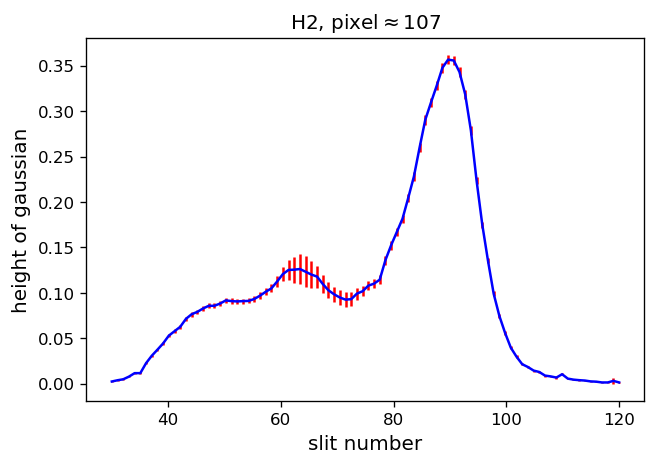

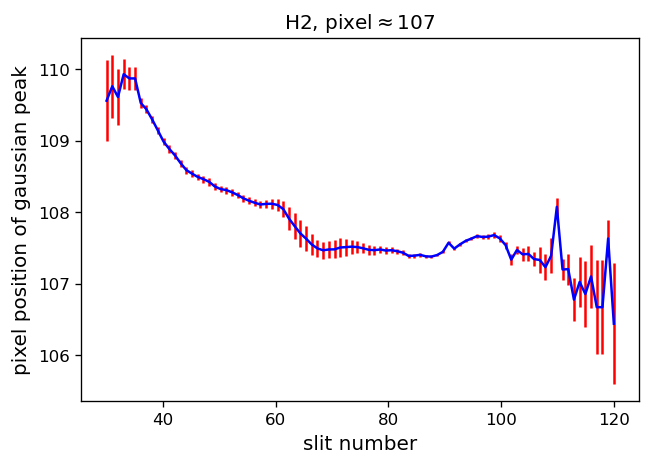

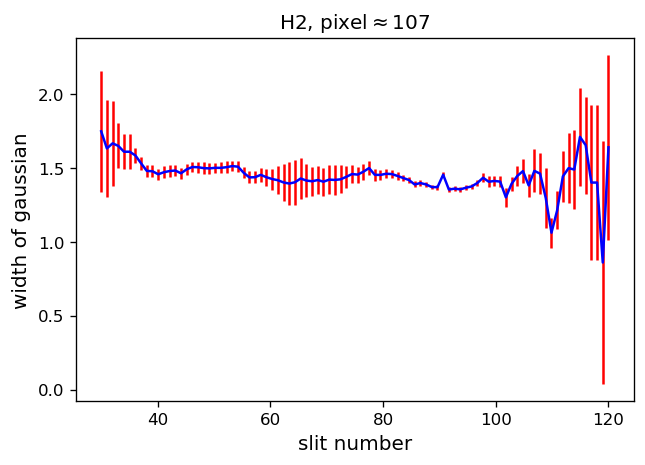

In [383]:
# create lmfit model with defined gaussian
h2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(h2_model.param_names))
#print('independent variables: {}'.format(h2_model.independent_vars))


# create parameters and add initial guess
h2_params = h2_model.make_params()
h2_params.add('a0', value=0.2)
h2_params.add('a1', value=107)
h2_params.add('a2', value=1)
h2_params.add('a3', value=0)
h2_params.add('a4', value=0)
h2_params.add('a5', value=0)


# create h2 lists for all slits
h2_a0 = []
h2_a0_error = []
h2_a1 = []
h2_a1_error = []
h2_a2 = []
h2_a2_error = []


# loop over all slits containing observed emission 
# and obtain fitting parameters of each slit
lower = 30
upper = 120

for i in range(lower, upper):
    try:
        h2_fit_result = h2_model.fit(sky_subtracted[i], h2_params, x=pixel)
    except:
        pass
    h2_a0.append(h2_fit_result.params['a0'].value)
    h2_a0_error.append(h2_fit_result.params['a0'].stderr)
    h2_a1.append(h2_fit_result.params['a1'].value)
    h2_a1_error.append(h2_fit_result.params['a1'].stderr)
    h2_a2.append(h2_fit_result.params['a2'].value)
    h2_a2_error.append(h2_fit_result.params['a2'].stderr)
h2_a0_array = np.array(h2_a0)
h2_a0_error_array = np.array(h2_a0_error)
h2_a1_array = np.array(h2_a1)
h2_a1_error_array = np.array(h2_a1_error)
h2_a2_array = np.array(h2_a2)
h2_a2_error_array = np.array(h2_a2_error)


# plot computed fitting parameters against pixels
h2_slit_number = np.linspace(lower, lower+len(h2_a0_array), len(h2_a0_array))

plt.figure(dpi=120)
plt.title(r'H2, pixel$\approx$107')
plt.xlabel('slit number', fontsize=12)
plt.ylabel('height of gaussian', fontsize=12)
plt.errorbar(h2_slit_number, h2_a0_array, yerr=h2_a0_error_array, ls='-', color='b', ecolor='r')

plt.figure(dpi=120)
plt.title(r'H2, pixel$\approx$107')
plt.xlabel('slit number', fontsize=12)
plt.ylabel('pixel position of gaussian peak', fontsize=12)
plt.errorbar(h2_slit_number, h2_a1_array, yerr=h2_a1_error_array, ls='-', color='b', ecolor='r')

plt.figure(dpi=120)
plt.title(r'H2, pixel$\approx$107')
plt.xlabel('slit number', fontsize=12)
plt.ylabel('width of gaussian', fontsize=12)
plt.errorbar(h2_slit_number, h2_a2_array, yerr=h2_a2_error_array, ls='-', color='b', ecolor='r')

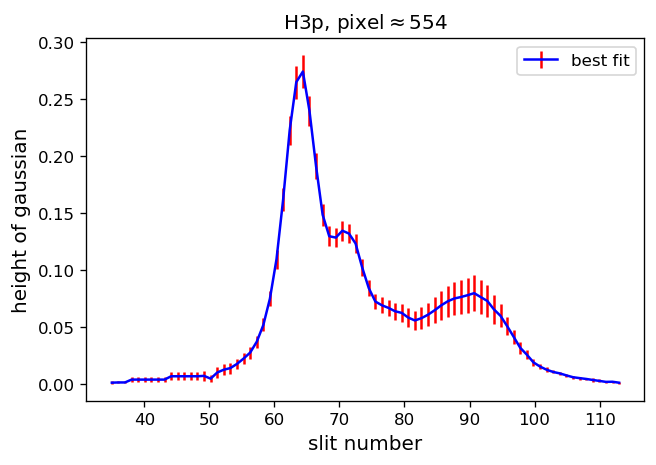

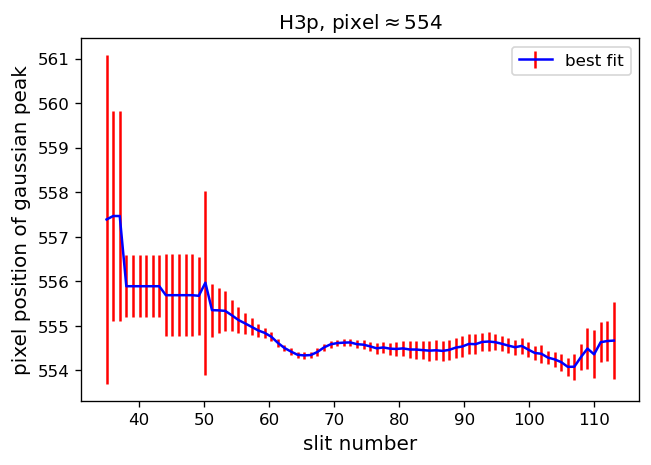

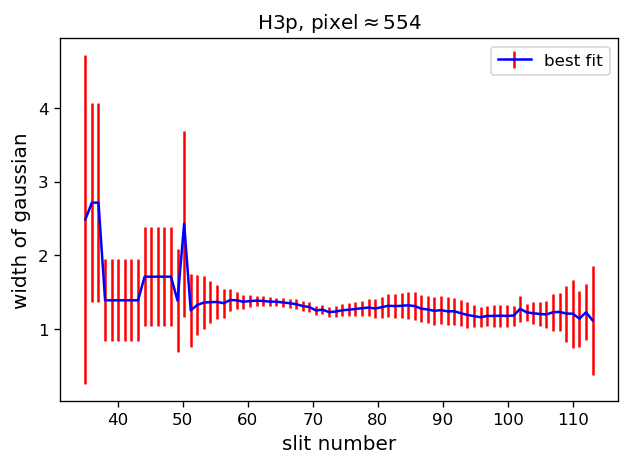

In [417]:
# create lmfit model with defined gaussian
h3p_model = Model(gaussian_fit)

h3p_params = h3p_model.make_params()
h3p_params.add('a0', value=0.02)
h3p_params.add('a1', value=554)
h3p_params.add('a2', value=1)
h3p_params.add('a3', value=0.03)
h3p_params.add('a4', value=0)
h3p_params.add('a5', value=0)


# create h3p lists for all slits
h3p_a0 = []
h3p_a0_error = []
h3p_a1 = []
h3p_a1_error = []
h3p_a2 = []
h3p_a2_error = []


# loop over all slits containing observed emission 
# and obtain fitting parameters of each slit
lower = 35
upper = 113
for i in range(lower, upper):
    try:
        h3p_fit_result = h3p_model.fit(sky_subtracted[i], h3p_params, x=pixel)
    except:
        pass
    h3p_a0.append(h3p_fit_result.best_values.get('a0'))
    h3p_a0_error.append(h3p_fit_result.params['a0'].stderr)
    h3p_a1.append(h3p_fit_result.best_values.get('a1'))
    h3p_a1_error.append(h3p_fit_result.params['a1'].stderr)
    h3p_a2.append(h3p_fit_result.best_values.get('a2'))
    h3p_a2_error.append(h3p_fit_result.params['a2'].stderr)
h3p_a0_array = np.array(h3p_a0)
h3p_a0_error_array = np.array(h3p_a0_error)
h3p_a1_array = np.array(h3p_a1)
h3p_a1_error_array = np.array(h3p_a1_error)
h3p_a2_array = np.array(h3p_a2)
h3p_a2_error_array = np.array(h3p_a2_error)

h3p_slit_number = np.linspace(lower, lower+len(h3p_a0_array), len(h3p_a0_array))

plt.figure(dpi=120)
plt.title(r'H3p, pixel$\approx$' + str(h3p_params.get('a1').value))
plt.xlabel('slit number', fontsize=12)
plt.ylabel('height of gaussian', fontsize=12)
#plt.plot(h3p_slit_number, h3p_a0_array)
plt.errorbar(h3p_slit_number, h3p_a0_array, yerr=h3p_a0_error_array, ls='-', color='b', ecolor='r', label='best fit')
plt.legend()

plt.figure(dpi=120)
plt.title(r'H3p, pixel$\approx$' + str(h3p_params.get('a1').value))
plt.xlabel('slit number', fontsize=12)
plt.ylabel('pixel position of gaussian peak', fontsize=12)
#plt.plot(h3p_slit_number, h3p_a1_array)
plt.errorbar(h3p_slit_number, h3p_a1_array, yerr=h3p_a1_error_array, ls='-', color='b', ecolor='r', label='best fit')
plt.legend()

plt.figure(dpi=120)
plt.title(r'H3p, pixel$\approx$' + str(h3p_params.get('a1').value))
plt.xlabel('slit number', fontsize=12)
plt.ylabel('width of gaussian', fontsize=12)
#plt.plot(h3p_slit_number, h3p_a2_array)
plt.errorbar(h3p_slit_number, h3p_a2_array, yerr=h3p_a2_error_array, ls='-', color='b', ecolor='r', label='best fit')
plt.legend()

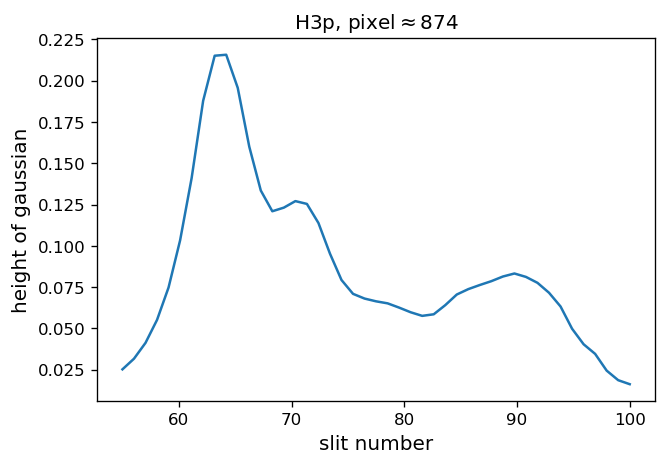

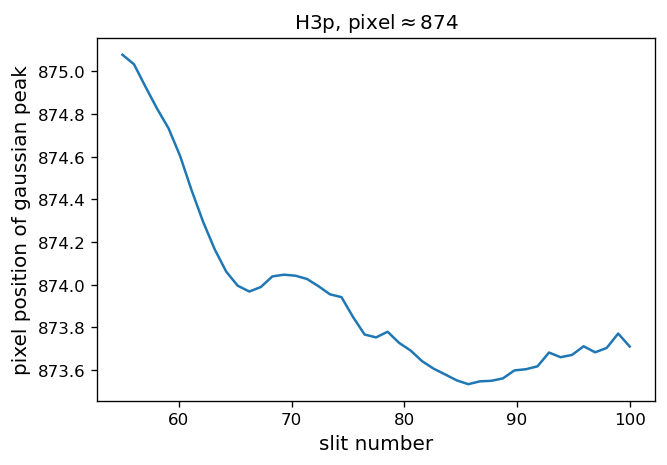

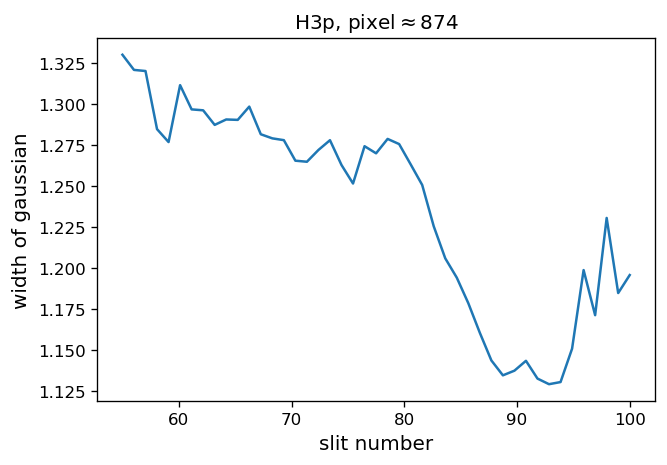

In [6]:
# create lmfit model with defined gaussian
h3p_model = Model(gaussian_fit)

h3p_params = h3p_model.make_params()
h3p_params.add('a0', value=0.02)
h3p_params.add('a1', value=874)
h3p_params.add('a2', value=1)
h3p_params.add('a3', value=0.03)
h3p_params.add('a4', value=0)
h3p_params.add('a5', value=0)

# create h3p lists for all slits
h3p_a0 = []
h3p_a1 = []
h3p_a2 = []

# loop over all slits containing observed emission 
# and obtain fitting parameters of each slit
# h3p emission ranges from approximately 55 to 100
for i in range(100-55):
    #y = sky_subtracted[i+40]
    h3p_all_result = h3p_model.fit(sky_subtracted[i+55], h3p_params, x=pixel)
    h3p_a0.append(h3p_all_result.best_values.get('a0'))
    h3p_a1.append(h3p_all_result.best_values.get('a1'))
    h3p_a2.append(h3p_all_result.best_values.get('a2'))
    #plt.plot(h3p_a0, label='fit')
    #plt.legend()
h3p_a0_array = np.array(h3p_a0)
h3p_a1_array = np.array(h3p_a1)
h3p_a2_array = np.array(h3p_a2)

h3p_slit_number = np.linspace(55, 55+len(h3p_a0_array), len(h3p_a0_array))

plt.figure(dpi=120)
plt.title(r'H3p, pixel$\approx$' + str(h3p_params.get('a1').value))
plt.xlabel('slit number', fontsize=12)
plt.ylabel('height of gaussian', fontsize=12)
plt.plot(h3p_slit_number, h3p_a0_array)

plt.figure(dpi=120)
plt.title(r'H3p, pixel$\approx$' + str(h3p_params.get('a1').value))
plt.xlabel('slit number', fontsize=12)
plt.ylabel('pixel position of gaussian peak', fontsize=12)
plt.plot(h3p_slit_number, h3p_a1_array)

plt.figure(dpi=120)
plt.title(r'H3p, pixel$\approx$' + str(h3p_params.get('a1').value))
plt.xlabel('slit number', fontsize=12)
plt.ylabel('width of gaussian', fontsize=12)
plt.plot(h3p_slit_number, h3p_a2_array)

# create lmfit model with defined gaussian
h2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(h2_model.param_names))
#print('independent variables: {}'.format(h2_model.independent_vars))
#print('-------------------------------------')

# create parameters and add initial guess
h2_params = h2_model.make_params()
h2_params.add('a0', value=0.06)
h2_params.add('a1', value=107)
h2_params.add('a2', value=1)
h2_params.add('a3', value=0)
h2_params.add('a4', value=0)
h2_params.add('a5', value=0)

# obtain cropped slit
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))
selected_slit = sky_subtracted[21]
#plt.figure(dpi=100)
#plt.plot(waverange, selected_slit, '.b')

new_pix = pixel[np.where((selected_slit < np.mean(selected_slit)+5.*np.std(selected_slit)) &
         (selected_slit > np.mean(selected_slit)-5.*np.std(selected_slit)) | (pixel > 100) & (pixel < 110))]

new_sli = selected_slit[np.where((selected_slit < np.mean(selected_slit)+5.*np.std(selected_slit)) &
         (selected_slit > np.mean(selected_slit)-5.*np.std(selected_slit)) | (pixel > 100) & (pixel < 110))]

# select certain waverange/pixel
#index = np.where((waverange>2.1216) & (waverange<2.12197))
#index = np.where((pixel>90)*(pixel<140))

# fit the model
h2_fit = h2_model.fit(new_sli, h2_params, x=new_pix)
#h2_fit = h2_model.fit(selected_slit, h2_params, x=pixel)

# print the result report
print(h2_fit.fit_report())

# plot the result against pixels
# x = pixel; y = selected_slit
plt.figure(dpi=100)
plt.plot(new_pix, new_sli,'b.', label='reduced')
plt.plot(new_pix, h2_fit.best_fit, 'r-', label='reduced best fit')
#plt.plot(pixel, selected_slit,'b.', label='original')
#plt.plot(pixel, h2_fit.best_fit, 'r-', label='best fit')
#plt.xlim(100, 120)
#plt.ylim(0, 0.05)
plt.legend(loc='best')

# create lmfit model with defined gaussian
h3p_model = Model(gaussian_fit)

h3p_params = h3p_model.make_params()
h3p_params.add('a0', value=0.02)
h3p_params.add('a1', value=554)
h3p_params.add('a2', value=2)
h3p_params.add('a3', value=0.03)
h3p_params.add('a4', value=0)
h3p_params.add('a5', value=0)

pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))
h3p_fit = h3p_model.fit(sky_subtracted[100], h3p_params, x=pixel)

#print(h3p_fit.fit_report())

plt.figure(dpi=100)
plt.plot(pixel, sky_subtracted[100], 'b.', label='original')
#plt.plot(x, result.init_fit, 'k--', label='initial fit')
plt.plot(pixel, h3p_fit.best_fit, 'r-', label='best fit')
plt.xlim(550, 560)
plt.legend(loc='best')
plt.show()

# create lmfit model with defined gaussian
h2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(h2_model.param_names))
#print('independent variables: {}'.format(h2_model.independent_vars))
#print('-------------------------------------')

# create parameters and add initial guess
h2_params = h2_model.make_params()
h2_params.add('a0', value=0.06)
h2_params.add('a1', value=107)
h2_params.add('a2', value=1)
h2_params.add('a3', value=0)
h2_params.add('a4', value=0)
h2_params.add('a5', value=0)

# create h2 lists for all slits
h2_a0_all = []
h2_a0_all_error = []
h2_a1_all = []
h2_a2_all = []
#h2_a3_all = []
#h2_a4_all = []
#h2_a5_all = []

# loop over all slits containing observed emission 
# and obtain fitting parameters of each slit
# h2 emission ranges from approximately 40 to 100
for i in range(20, 125):
    try:
        h2_all_result = h2_model.fit(sky_subtracted[i], h2_params, x=pixel)
    except:
        i == 1
    h2_a0_all.append(h2_all_result.best_values.get('a0'))
    h2_a1_all.append(h2_all_result.best_values.get('a1'))
    h2_a2_all.append(h2_all_result.best_values.get('a2'))
    #h2_a3_all.append(h2_all_result.best_values.get('a3'))
    #h2_a4_all.append(h2_all_result.best_values.get('a4'))
    #h2_a5_all.append(h2_all_result.best_values.get('a5'))
h2_a0_all_array = np.array(h2_a0_all)
h2_a1_all_array = np.array(h2_a1_all)
h2_a2_all_array = np.array(h2_a2_all)
#h2_a3_all_array = np.array(h2_a3_all)
#h2_a4_all_array = np.array(h2_a4_all)
#h2_a5_all_array = np.array(h2_a5_all)

# plot computed fitting parameters against pixels
h2_slit_number = np.linspace(20, 20+len(h2_a0_all_array), len(h2_a0_all_array))

plt.figure(dpi=120)
plt.title(r'H2, pixel$\approx$107')
plt.xlabel('slit number', fontsize=12)
plt.ylabel('height of gaussian', fontsize=12)
plt.plot(h2_slit_number, h2_a0_all_array)

plt.figure(dpi=120)
plt.title(r'H2, pixel$\approx$107')
plt.xlabel('slit number', fontsize=12)
plt.ylabel('pixel position of gaussian peak', fontsize=12)
plt.plot(h2_slit_number, h2_a1_all_array)

plt.figure(dpi=120)
plt.title(r'H2, pixel$\approx$107')
plt.xlabel('slit number', fontsize=12)
plt.ylabel('width of gaussian', fontsize=12)
plt.plot(h2_slit_number, h2_a2_all_array)

# create lmfit model with defined gaussian
h3p_model = Model(gaussian_fit)

h3p_params = h3p_model.make_params()
h3p_params.add('a0', value=0.02)
h3p_params.add('a1', value=874)
h3p_params.add('a2', value=1)
h3p_params.add('a3', value=0.03)
h3p_params.add('a4', value=0)
h3p_params.add('a5', value=0)

pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))
h3p_fit = h3p_model.fit(sky_subtracted[100], h3p_params, x=pixel)

#print(h3p_fit.fit_report())

plt.figure(dpi=100)
plt.title('slit 100')
plt.plot(pixel, sky_subtracted[100], 'b.', label='original')
#plt.plot(x, result.init_fit, 'k--', label='initial fit')
plt.plot(pixel, h3p_fit.best_fit, 'r-', label='best fit')
#plt.xlim(552, 556)
plt.legend(loc='best')
plt.show()

#gmodel = Model(gaussian_fit)
h3p_model = Model(gaussian_fit, prefix='g1_') + Model(gaussian_fit, prefix='g2_') +\
        Model(gaussian_fit, prefix='g3_') + Model(gaussian_fit, prefix='g4_') +\
        Model(gaussian_fit, prefix='g5_') + Model(gaussian_fit, prefix='g6_') + Model(gaussian_fit, prefix='g7_')
#print('parameter names: {}'.format(gmodel.param_names))
#print('independent variables: {}'.format(gmodel.independent_vars))

#params = gmodel.make_params(a0=0.005, a1=74, a2=1, a3=0.1, a4=0, a5=0)
h3p_params = h3p_model.make_params()

# add parameters for 1st fit
h3p_params.add('g1_a0', value=0.005)
h3p_params.add('g1_a1', value=74)
h3p_params.add('g1_a2', value=1)
h3p_params.add('g1_a3', value=0.003)
h3p_params.add('g1_a4', value=0)
h3p_params.add('g1_a5', value=0)

# add parameters for 2nd fit
h3p_params.add('g2_a0', value=0.008)
h3p_params.add('g2_a1', value=117)
h3p_params.add('g2_a2', value=1)
h3p_params.add('g2_a3', value=0.003)
h3p_params.add('g2_a4', value=0)
h3p_params.add('g2_a5', value=0)

# add parameters for 3rd fit
h3p_params.add('g3_a0', value=0.006)
h3p_params.add('g3_a1', value=322)
h3p_params.add('g3_a2', value=1)
h3p_params.add('g3_a3', value=0.003)
h3p_params.add('g3_a4', value=0)
h3p_params.add('g3_a5', value=0)

# add parameters for 4th fit
h3p_params.add('g4_a0', value=0.003)
h3p_params.add('g4_a1', value=452)
h3p_params.add('g4_a2', value=1)
h3p_params.add('g4_a3', value=0.003)
h3p_params.add('g4_a4', value=0)
h3p_params.add('g4_a5', value=0)

# add parameters for 5th fit
h3p_params.add('g5_a0', value=0.02)
h3p_params.add('g5_a1', value=554)
h3p_params.add('g5_a2', value=1)
h3p_params.add('g5_a3', value=0.003)
h3p_params.add('g5_a4', value=0)
h3p_params.add('g5_a5', value=0)

# add parameters for 6th fit
h3p_params.add('g6_a0', value=0.01)
h3p_params.add('g6_a1', value=682)
h3p_params.add('g6_a2', value=1)
h3p_params.add('g6_a3', value=0.003)
h3p_params.add('g6_a4', value=0)
h3p_params.add('g6_a5', value=0)

# add parameters for 7th fit
h3p_params.add('g7_a0', value=0.02)
h3p_params.add('g7_a1', value=874)
h3p_params.add('g7_a2', value=1)
h3p_params.add('g7_a3', value=0.003)
h3p_params.add('g7_a4', value=0)
h3p_params.add('g7_a5', value=0)


h3p_fit = h3p_model.fit(sky_subtracted[100], h3p_params, x=pixel)

#print(h3p_fit.fit_report())

plt.figure(dpi=100)
plt.title('slit 100')
plt.plot(pixel, sky_subtracted[100], 'b.', label='original')
#plt.plot(x, result.init_fit, 'k--', label='initial fit')
plt.plot(pixel, h3p_fit.best_fit, 'r-', label='best fit')
#plt.xlim(552, 556)
plt.legend(loc='best')
plt.show()